In [1]:
from qiskit.compiler import transpile, schedule, assemble
from qiskit.circuit.library import RZXGate
import pickle
from qiskit import execute, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ
from qiskit.transpiler.passes.scheduling.calibration_creators import RZXCalibrationBuilder

In [2]:
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter, TomographyFitter
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info.operators.channel import Choi, Kraus, PTM
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate
from scipy.optimize import curve_fit

In [3]:
from qiskit.providers.aer.noise.errors.errorutils import standard_gate_unitary
from qiskit.quantum_info.operators.measures import process_fidelity
from qiskit.quantum_info import Choi, Kraus, Operator
import qiskit.quantum_info as qi

# Backend Set-up

In [4]:
provider = IBMQ.load_account()

In [5]:
#provider = IBMQ.save_account('bc105c39d9a7126c0d0676289f99065f525c6d739c807848153f6d1dd19907d6d433577b8c34a1959654f82f12418f09d115a1b8eb3db8dab6fabe1192da1643',overwrite=True)

In [6]:
provider_pulse = IBMQ.get_provider(hub='ibm-q-startup', group='phasecraft-ltd', project='pulse-level-cont')

In [40]:
#provider_pulse = IBMQ.get_provider(hub='ibm-q-startup', group='phasecraft-ltd', project='reservations')#),mode='dedicated')#,reservation_id='60b647d6325afee40d368968')

In [7]:
# casablanca or bogota for our pulse experiments
device_name = "ibmq_casablanca"
backend = provider_pulse.get_backend('ibmq_casablanca')

In [8]:
# from backend
config = backend.configuration()
props = backend.properties()
defaults = backend.defaults()

assert config.open_pulse, "Backend doesn't support Pulse"

In [9]:
# default calibrations, basis gates and instruction map
basis_gates = config.basis_gates
dt = config.dt
inst_map = defaults.instruction_schedule_map
RZX_cals = RZXCalibrationBuilder(backend)

In [10]:
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds


Sampling time: 0.2222222222222222 ns


In [11]:
print(inst_map)

<InstructionScheduleMap(1Q instructions:
  q0: {'sx', 'measure', 'u2', 'x', 'u3', 'rz', 'u1', 'id'}
  q1: {'sx', 'measure', 'u2', 'x', 'u3', 'rz', 'u1', 'id'}
  q2: {'sx', 'measure', 'u2', 'x', 'u3', 'rz', 'u1', 'id'}
  q3: {'sx', 'measure', 'u2', 'x', 'u3', 'rz', 'u1', 'id'}
  q4: {'sx', 'measure', 'u2', 'x', 'u3', 'rz', 'u1', 'id'}
  q5: {'sx', 'measure', 'u2', 'x', 'u3', 'rz', 'u1', 'id'}
  q6: {'sx', 'measure', 'u2', 'x', 'u3', 'rz', 'u1', 'id'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 5): {'cx'}
  (4, 5): {'cx'}
  (5, 3): {'cx'}
  (5, 4): {'cx'}
  (5, 6): {'cx'}
  (6, 5): {'cx'}
  (0, 1, 2, 3, 4, 5, 6): {'measure'}
)>


# RZ Pulse Tomography

## Choose specific qubits and angles 

In [12]:
label = '02.June'

In [49]:
##### pick qubits and angles
# will define custom gates for just this pair of qubits and these angles
# then we link the CR scaled RZ schedules to our custom gates

qubits = (4, 5)

number_of_angles = 60
angles = np.round(
                 #np.random.uniform(0.1, 2*np.pi, number_of_angles),
                  np.linspace(0.1, 2*np.pi, number_of_angles),
                  2)

In [50]:
angles

array([0.1 , 0.2 , 0.31, 0.41, 0.52, 0.62, 0.73, 0.83, 0.94, 1.04, 1.15,
       1.25, 1.36, 1.46, 1.57, 1.67, 1.78, 1.88, 1.99, 2.09, 2.2 , 2.3 ,
       2.41, 2.51, 2.62, 2.72, 2.82, 2.93, 3.03, 3.14, 3.24, 3.35, 3.45,
       3.56, 3.66, 3.77, 3.87, 3.98, 4.08, 4.19, 4.29, 4.4 , 4.5 , 4.61,
       4.71, 4.82, 4.92, 5.03, 5.13, 5.24, 5.34, 5.44, 5.55, 5.65, 5.76,
       5.86, 5.97, 6.07, 6.18, 6.28])

In [51]:
rz_schedules = {str(angle): RZX_cals.get_calibration([angle] , qubits) for angle in angles}

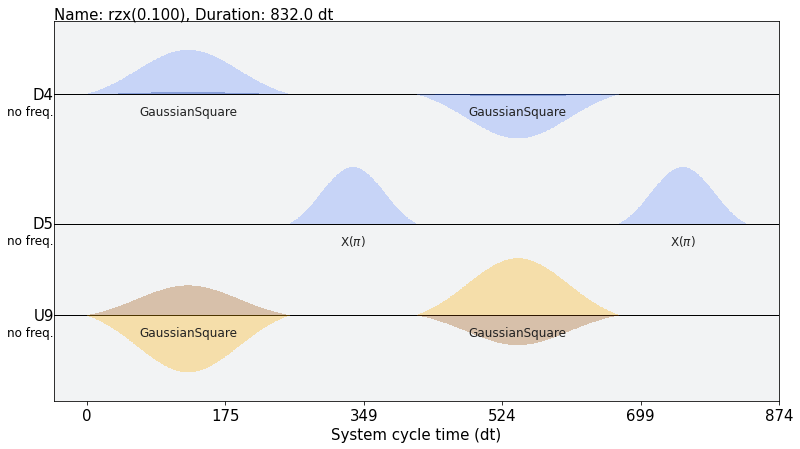

In [52]:
# the shortest duration pulse schedule, gaussian square pulses are the CR pulse that get scales with the angle
rz_schedules[str(min(angles))].draw()

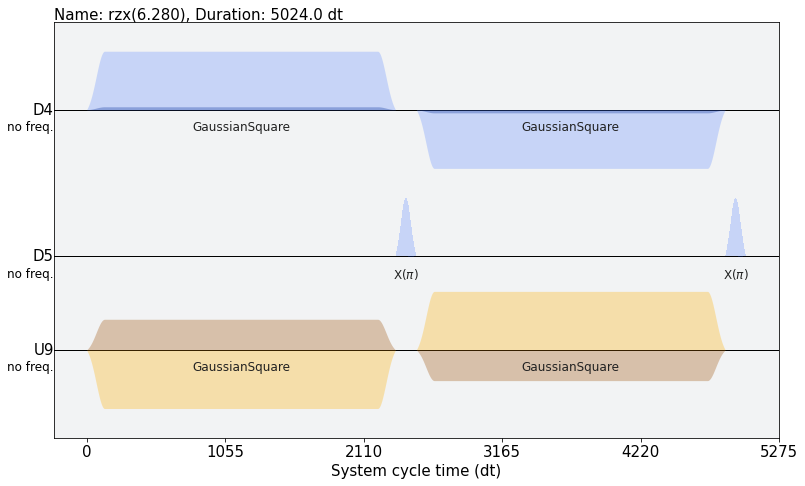

In [53]:
# contrast with longest pulse schedule
rz_schedules[str(max(angles))].draw()

In [54]:
rz_schedule_durations = [rz_schedules[f'{angle}'].duration/(dt*1e9) for angle in angles]

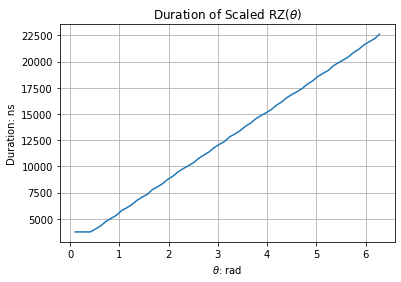

In [55]:

plt.plot(angles, rz_schedule_durations)
plt.xlabel(r'$\theta$: rad')
plt.ylabel('Duration: ns')
plt.title(r'Duration of Scaled RZ($\theta$)')
plt.grid()
plt.show()

## Adding custom gate names and linking them to the scaled pulse schedules

In [56]:
for angle in angles:
    gate_name = f'rzx_{angle}'
    basis_gates += [gate_name]
    inst_map.add(gate_name, qubits, rz_schedules[str(angle)])

In [57]:
print(f'Updated instruction schedule map: \n\n {inst_map}')

Updated instruction schedule map: 

 <InstructionScheduleMap(1Q instructions:
  q0: {'x', 'sx', 'measure', 'u3', 'id', 'rz', 'u2', 'u1'}
  q1: {'x', 'sx', 'measure', 'u3', 'id', 'rz', 'u2', 'u1'}
  q2: {'x', 'sx', 'measure', 'u3', 'id', 'rz', 'u2', 'u1'}
  q3: {'x', 'sx', 'measure', 'u3', 'id', 'rz', 'u2', 'u1'}
  q4: {'x', 'sx', 'measure', 'u3', 'id', 'rz', 'u2', 'u1'}
  q5: {'x', 'sx', 'measure', 'u3', 'id', 'rz', 'u2', 'u1'}
  q6: {'x', 'sx', 'measure', 'u3', 'id', 'rz', 'u2', 'u1'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 5): {'cx'}
  (4, 5): {'cx'}
  (5, 3): {'cx'}
  (5, 4): {'rzx_1.46', 'rzx_0.94', 'rzx_3.98', 'rzx_2.82', 'rzx_4.29', 'rzx_4.92', 'rzx_4.08', 'rzx_0.52', 'rzx_5.03', 'rzx_0.1', 'rzx_3.03', 'rzx_3.77', 'rzx_2.72', 'rzx_5.13', 'rzx_5.55', 'rzx_2.51', 'rzx_5.86', 'rzx_1.25', 'rzx_1.88', 'rzx_3.87', 'rzx_0.41', 'rzx_3.35', 'rzx_1.78', 'rzx_0.2', 'rzx_5.44', 'rzx_3.56', 'rzx_5.65

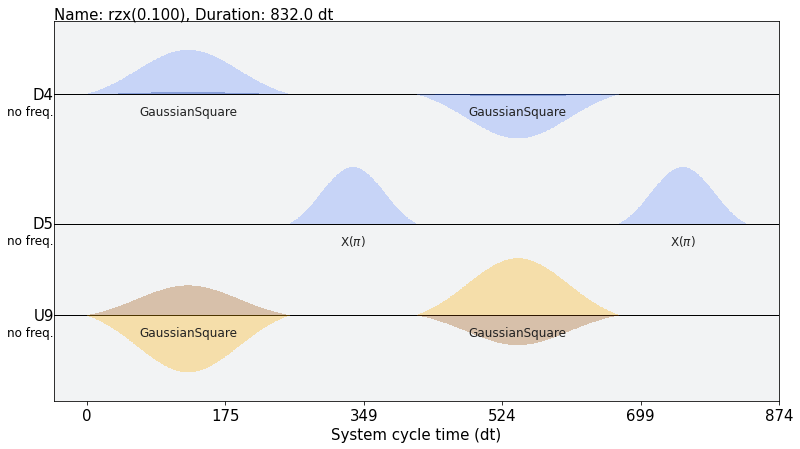

In [58]:
# checking that the correct shedule is linked to the correct gate name
inst_map.get(f'rzx_{min(angles)}', qubits).draw()

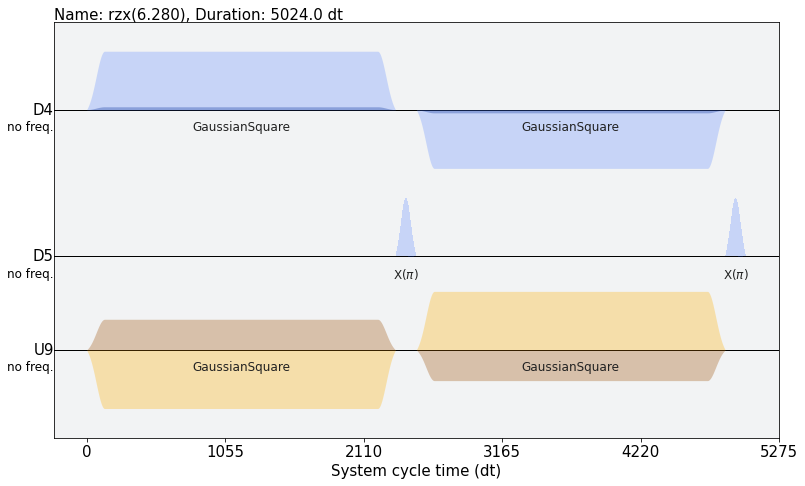

In [59]:
inst_map.get(f'rzx_{max(angles)}', qubits).draw()

## Setting up the tomography circuits

In [60]:
# our custom gates that we need to make tomography circuits for
gates = {str(angle): Gate(f'rzx_{angle}', 2, []) for angle in angles}

In [ ]:
qpt_experiments = {}

for angle in angles:
    
    qregs = QuantumRegister(config.n_qubits)
    
    gate = gates[str(angle)]
    circuit = QuantumCircuit(qregs)
    circuit.compose(gate, [qregs[qubits[0]], qregs[qubits[1]]], inplace=True) 
    
    qpt_circuits = process_tomography_circuits(circuit, [qregs[qubits[0]], qregs[qubits[1]]]) 
    qpt_circuits_transpiled = transpile(qpt_circuits, backend, basis_gates) # withou
    qpt_schedules = schedule(qpt_circuits_transpiled, backend, inst_map)
    
    qpt_experiments[str(angle)] = {'pre_transpiled_circuits': qpt_circuits,
                                   'transpiled_circuits': qpt_circuits_transpiled,
                                   'qpt_schedules': qpt_schedules}

In [ ]:
#doesn't know how to do hadamard on this device without transpiling etc
qpt_experiments[f'{min(angles)}']['pre_transpiled_circuits'][40].draw()

In [ ]:
qpt_experiments[f'{min(angles)}']['qpt_schedules'][40].draw()

In [ ]:
qpt_schedule_durations = [qpt_experiments[f'{angle}']['qpt_schedules'][0].duration/(dt*1e9) for angle in angles]

In [ ]:
#measurement pulse really dominates!!!! 
plt.plot(angles, qpt_schedule_durations, label='with measurement')
plt.plot(angles, rz_schedule_durations, label='no measurement')
plt.xlabel(r'$\theta$: rad')
plt.ylabel('Duration: ns')
plt.title(r'RZ($\theta$) via scaled pulses')
plt.grid()
plt.legend()
plt.savefig('plots/measurement_cost.png', transparent=False)
plt.show()

### Actually submitting jobs

In [ ]:
angles

In [ ]:
results = {}
for angle in angles:
    qpt_sched = qpt_experiments[str(angle)]['qpt_schedules']
    job = execute(qpt_sched, backend=backend, shots=500)#,mode='dedicated')
    result = job.result()
    results[f'{angle}'] = result

# Unscaled Pulse Schedules

In [ ]:
qpt_experiments_cx = {}

for angle in angles:
    
    qregs = QuantumRegister(config.n_qubits)
    
    gate = RZXGate(angle)
    circuit = QuantumCircuit(qregs)
    circuit.compose(gate, [qregs[qubits[0]], qregs[qubits[1]]], inplace=True) 
    
    qpt_circuits_cx  = process_tomography_circuits(circuit, [qregs[qubits[0]], qregs[qubits[1]]]) 
    qpt_circuits_transpiled_cx = transpile(qpt_circuits_cx, backend, basis_gates) # withou
    qpt_schedules_cx = schedule(qpt_circuits_transpiled_cx, backend, inst_map)
    
    qpt_experiments_cx[str(angle)] = {'pre_transpiled_circuits': qpt_circuits_cx,
                                   'transpiled_circuits': qpt_circuits_transpiled_cx,
                                   'qpt_schedules': qpt_schedules_cx}

In [ ]:
#doesn't know how to do hadamard on this device without transpiling etc
qpt_experiments_cx[f'{min(angles)}']['pre_transpiled_circuits'][0].draw()

In [ ]:
#double cnot method: default alternative
qpt_experiments_cx[f'{min(angles)}']['qpt_schedules'][40].draw()

In [ ]:
qpt_schedule_durations_cx = [qpt_experiments_cx[f'{angle}']['qpt_schedules'][0].duration/(dt*1e9) for angle in angles]

In [ ]:
# So there's a crossover point
plt.plot(angles, qpt_schedule_durations)
plt.plot(angles, qpt_schedule_durations_cx)
plt.xlabel(r'$\theta$: rad')
plt.ylabel('Duration: ns')
plt.title(r'Duration of RZ($\theta$)')
plt.grid()
plt.savefig('plots/duration_crossover.png', transparent=False)
plt.show()

### Actually submitting jobs

In [ ]:
results_cx = {}

for angle in angles:
    qpt_sched_cx = qpt_experiments_cx[str(angle)]['qpt_schedules']
    job = execute(qpt_sched_cx, backend=backend, shots=300)
    result = job.result()
    results_cx[f'{angle}'] = result
  
    

In [ ]:
#with open(f'results/{device_name}/{label}/2q_tomography/unscaledCR.q4q5.pickle', 'wb') as handle:
 #   pickle.dump(results_cx, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Getting Fidelities

In [ ]:
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.4f} + {:.4f}x'.format(a, b))

    return a, b



In [ ]:
label = '25.May'

In [ ]:
label = '25.May'
with open(f'results/{device_name}/{label}/2q_tomography/scaledCR.q4q5.pickle', 'rb') as handle:
    results = pickle.load(handle)
    
#label = '24.May'
#with open(f'results/{device_name}/{label}/2q_tomography/unscaledCR.q4q5.pickle', 'rb') as handle:
 #   results_cx = pickle.load(handle)

In [ ]:
fidelities = {}
#fidelities_cx = {}
#ratios = {}

q2 = QuantumRegister(2)
d= 2*np.pi/1.2

for angle in angles:
    
    qpt_circuits = qpt_experiments[str(angle)]['transpiled_circuits']
   # qpt_circuits_cx = qpt_experiments_cx[str(angle)]['transpiled_circuits']
    
    res = results[str(angle)]
   # res_cx = results_cx[str(angle)]
    
    process_data = ProcessTomographyFitter(res, qpt_circuits, meas_basis='Pauli', prep_basis='Pauli')
    #process_data_cx = ProcessTomographyFitter(res_cx, qpt_circuits_cx, meas_basis='Pauli', prep_basis='Pauli')
    
    choi_fit = process_data.fit( )#method='cvx', standard_weights=True,kwargs={ "trace_preserving":True, "PSD": True})
    #choi_fit_cx = process_data_cx.fit( )#method='cvx', standard_weights=True,kwargs={ "trace_preserving":True, "PSD": True})
        
    choi_fit = choi_fit.data
    #choi_fit_cx = choi_fit_cx.data
   
    ideal_circ = QuantumCircuit(q2)
    ideal_circ.rzx(angle*(1+d),q2[0],q2[1])
    ideal_op_data = qi.Operator(ideal_circ).data
    

        
  #  fid_cx = qi.process_fidelity(channel=Choi(choi_fit_cx),target=Operator(ideal_op_data))
    fid = qi.process_fidelity(channel=Choi(choi_fit),target=qi.Operator(ideal_op_data)) 
  
    fidelities[str(angle)] = fid
   # fidelities_cx[str(angle)] = fid_cx
   # ratios[str(angle)] = fid/fid_cx

In [ ]:
plt.plot(angles, list(fidelities.values()),c='r')

plt.xlabel(r'$\theta$: rad')
plt.ylabel(r'$F(\theta)$')
plt.title(r'RZ($\theta$) via Scaled Pulses')
plt.savefig(f'plots/{label}.scaled_fid.png')
plt.grid()


In [ ]:
def func_cos(t, f, a, phi, offset):
    
    return a*np.cos(2*np.pi*f*t - phi) + offset

def fit_func_cos(ts, values, p0):
    
    return curve_fit(func_cos, ts, values, p0=p0)




In [ ]:
data_fit,_ = fit_func_cos(angles[0:15],list(fidelities.values())[0:15], p0=[0.81413938, 0.02526407, 1.08726345, 0.92397951])


In [ ]:
1/data_fit[0]

In [ ]:
plt.plot(angles[0:15], list(fidelities.values())[0:15],c='r')
plt.plot(angles[0:15], [func_cos(t, *data_fit) for t in angles][0:15])#, s=10
plt.xlabel(r'$\theta$: rad')
plt.ylabel(r'$F(\theta)$')
plt.title(r'RZ($\theta$) via Scaled Pulses')
plt.grid()


In [ ]:
a_cx, b_cx = best_fit(angles, fidelities_cx.values())
yfit_cx = [a_cx + b_cx * xi for xi in angles]
plt.plot(angles, yfit_cx, color='b')
plt.scatter(angles, fidelities_cx.values(), color='b')

plt.xlabel(r'$\theta$: rad')
plt.ylabel(r'$F(\theta)$')
plt.title(r'RZ($\theta$) via CNOTs')
plt.grid()
plt.savefig('plots/cx_fid.png', transparent=False)


In [ ]:
a, b = best_fit(angles, fidelities.values())
yfit = [a + b * xi for xi in angles]
plt.plot(angles, yfit, color='r', label='pulses')
plt.scatter(angles, fidelities.values(), color='r')


a_cx, b_cx = best_fit(angles, fidelities_cx.values())
yfit_cx = [a_cx + b_cx * xi for xi in angles]
plt.plot(angles, yfit_cx, color='b', label='CNOTs')
plt.scatter(angles, fidelities_cx.values(), color='b')

plt.xlabel(r'$\theta$: rad')
plt.ylabel(r'$F(\theta)$')
plt.title(r'RZ($\theta$)')
plt.grid()
plt.legend(loc=1)

plt.savefig('plots/scaled_and_cx.png', transparent=False)


In [ ]:
a_r, b_r = best_fit(angles, ratios.values())
yfit_r = [a_r + b_r * xi for xi in angles]
plt.plot(angles, yfit_r, color='g')
plt.scatter(angles, ratios.values(), color='g')

plt.xlabel(r'$\theta$: rad')
plt.ylabel(r'$F(\theta)$')
plt.title(r'RZ($\theta$) Fidelity Ratio')
plt.grid()
plt.savefig('plots/ratio_fid.png', transparent=False)


## Frequencies in Signal?

In [ ]:
sp = np.fft.fft(list(fidelities.values()))
freq = list(np.fft.fftfreq(angles.shape[-1]))
plt.plot(freq[1:], list(sp.real)[1:])
plt.plot(freq[1:],  list(sp.imag)[1:])
plt.grid()
plt.xlabel(r'Frequency')
plt.ylabel(r'Amplitude')
plt.title(r'RZ($\theta$) via pulse')
plt.savefig('plots/DFTofScaled.png', transparent=False)

plt.show()

In [ ]:
#checking signal is hermitian
np.conj(np.array(list(fidelities_cx.values())).T) - np.array(list(fidelities_cx.values()))

In [ ]:
signal = np.array(list(fidelities.values()))
n = signal.size
sample_rate = 1#1/dt
hdft=np.fft.hfft(signal)
plt.plot(hdft[1:])
plt.grid()
plt.xlabel(r'Frequency')
plt.ylabel(r'Amplitude')
plt.title(r'RZ($\theta$) via pulse')
plt.savefig('plots/DFTofScaled.png', transparent=False)

plt.show()

In [ ]:
hdft[8]

In [ ]:
2*np.pi*8/60

In [ ]:
signal = np.array(list(fidelities.values()))
n = signal.size
sample_rate = 1#1/dt
spr = list(np.fft.rfft(signal).real)
spi = list(np.fft.rfft(signal).imag)
freq = list(np.fft.rfftfreq(n, d=1./sample_rate))
plt.plot(freq, [0]+spr[1:], freq, [0]+spi[1:])
plt.grid()
plt.xlabel(r'Frequency')
plt.ylabel(r'Amplitude')
plt.title(r'RZ($\theta$) via pulse')
plt.savefig('plots/DFTofScaled.png', transparent=False)

plt.show()

In [ ]:
print(spr[1],
freq[1])

In [ ]:
sp = np.fft.hfft(list(fidelities_cx.values()))
#freq = list(np.fft.fftfreq(angles.shape[-1]))
#plt.plot(freq[10:]+freq[1:10], list(sp.real[10:])+list(sp.real[1:10]))
#plt.plot(freq[10:]+freq[1:10],  list(sp.imag[10:])+list(sp.imag[1:10]))
plt.plot([0]+list(sp[1:]))
plt.grid()
plt.xlabel(r'Frequency')
plt.ylabel(r'Amplitude')
plt.title(r'RZ($\theta$) via CNOTs')
plt.savefig('plots/DFTofUnscaled.png', transparent=False)

plt.show()

In [ ]:
noiseless_fids = {}



def func(angle, p, d):
    
    q2 = QuantumRegister(2)

    ideal_circ = QuantumCircuit(q2)
    ideal_circ.rzx(angle,q2[0],q2[1])
    ideal_op_data=qi.Operator(ideal_circ).data
    
   
    er_circ = QuantumCircuit(q2)
    er_circ.rzx(angle*(1+d),q2[0],q2[1])
    er_op_data = qi.Operator(er_circ).data
    
    actual_kraus=qi.Kraus([np.sqrt((1-p))*ideal_op_data, np.sqrt(p)*er_op_data])
  #  print(actual_kraus)
      
    fid = qi.process_fidelity(channel=actual_kraus, target=qi.Operator(ideal_op_data))
    
    return fid

In [ ]:
d

In [ ]:
p = 1
d = 2409413241.3922224/(2*np.pi)
plt.plot(angles, list(fidelities.values()), color='r')#, s
plt.plot(angles, [func(a,p,d) for a in angles], color='b')#, s

In [ ]:
defaults.qubit_freq_est[4]

In [ ]:
defaults.meas_freq_est[4]-defaults.qubit_freq_est[4]

In [ ]:
dir(defaults)

In [ ]:
config.sample_rate